<a href="https://colab.research.google.com/github/MirandaCarou/Research-Intership-Memory/blob/main/Quantum_autoencoder_1p1Q.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ijson
!pip install qiskit
!pip install qiskit_machine_learning
!pip install matplotlib
!pip install pylatexenc

In [2]:
import ijson
import numpy as np
import json
from decimal import Decimal
import json
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.quantum_info import Statevector
#from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
#from qiskit_machine_learning.neural_networks import SamplerQNN

In [3]:
datos = []
with open('ATLAS_events_v0.json', 'r', encoding='utf-8') as f:
    for item in ijson.items(f, 'item'):
        datos.append(item)
        if len(datos) >= 100:
            break

print(len(datos))

100


In [4]:
def decimal_to_float(data):
    if isinstance(data, Decimal):
        return float(data)
    elif isinstance(data, dict):
        return {key: decimal_to_float(value) for key, value in data.items()}
    elif isinstance(data, list):
        return [decimal_to_float(item) for item in data]
    else:
        return data  # Para int, str, etc.

def filtrar_jets(datos):
    eventos_con_jets = []

    for evento in datos:
        # Buscamos la clave 'jets' (case insensitive)
        jets = evento.get('jets') or evento.get('Jets') or evento.get('JETS')

        if jets and len(jets) > 0:  # Si hay al menos un jet
            # Filtramos cada jet para quedarnos solo con phi, pt y eta
            jets_filtrados = sorted(
                (
                    {
                        'pt': jet['pt'],
                        'eta': jet['eta'],
                        'phi': jet['phi'],
                        'btag_prob': jet['btag_prob']
                    }
                    for jet in jets
                    if all(k in jet for k in ['pt', 'eta', 'phi'])
                ),
                key=lambda x: x['pt'],
                reverse=True  # Orden descendente
            )
            if jets_filtrados:  # Si quedaron jets después del filtrado
                nuevo_evento = {'Jets': jets_filtrados}
                eventos_con_jets.append(nuevo_evento)

    return eventos_con_jets

def top_jets_por_btag(datos_filtrados, top_n=7):
    todos_jets = [jet for evento in datos_filtrados if 'Jets' in evento for jet in evento['Jets']]
    jets_ordenados = sorted(todos_jets, key=lambda x: x['btag_prob'], reverse=True)[:top_n]
    return jets_ordenados

def encontrar_maximos(datos_filtrados):
    max_pt = -float('inf')
    max_eta = -float('inf')
    max_phi = -float('inf')

    for evento in datos_filtrados:
        if 'Jets' in evento:
            for jet in evento['Jets']:
                max_pt = max(max_pt, jet['pt'])
                max_eta = max(max_eta, jet['eta'])
                max_phi = max(max_phi, jet['phi'])

    return max_pt, max_eta, max_phi

filtered_data = filtrar_jets(datos)
filtered_data_float = [decimal_to_float(event) for event in filtered_data]
pt_jet, eta_jet, phi_jet = encontrar_maximos(filtered_data_float)
top_jets_por_btag = top_jets_por_btag(filtered_data_float, top_n=10)
top_jets_float = [decimal_to_float(jet) for jet in top_jets_por_btag]

print(top_jets_float)

[{'pt': 143141.546875, 'eta': 0.663794755935669, 'phi': 1.9014869928359985, 'btag_prob': 0.9996816515922546}, {'pt': 14929.765625, 'eta': -4.614005088806152, 'phi': -0.07004830986261368, 'btag_prob': 0.8312855958938599}, {'pt': 12844.748046875, 'eta': 1.3619941473007202, 'phi': 1.6301140785217285, 'btag_prob': 0.7681667804718018}, {'pt': 17875.80859375, 'eta': 4.585882663726807, 'phi': 2.1506857872009277, 'btag_prob': 0.7554056644439697}, {'pt': 15793.01171875, 'eta': -1.843572974205017, 'phi': -2.6416432857513428, 'btag_prob': 0.7535187005996704}, {'pt': 73502.796875, 'eta': -0.8156948089599609, 'phi': -2.6390669345855713, 'btag_prob': 0.7220556735992432}, {'pt': 18507.45703125, 'eta': -4.570228099822998, 'phi': -2.6490488052368164, 'btag_prob': 0.7216451168060303}, {'pt': 14950.3525390625, 'eta': 4.547110557556152, 'phi': -1.584390640258789, 'btag_prob': 0.7100571990013123}, {'pt': 20751.47265625, 'eta': 1.199631929397583, 'phi': -0.9399804472923279, 'btag_prob': 0.707728385925293}, 



> ***“Each event is represented by a set of reconstructed jets ordered by decreasing transverse momentum (pT)…"***

Siguiendo con lo especificado en el paper....

\begin{align}
f \cdot \frac{p_T}{p_{T,\text{jet}}} \cdot (\eta - \eta_{\text{jet}}) \rightarrow \theta \tag{1} \\
f \cdot \frac{p_T}{p_{T,\text{jet}}} \cdot (\phi - \phi_{\text{jet}}) \rightarrow \varphi \tag{2} \\
(p_T, \eta, \phi) \rightarrow |\psi\rangle = R_X(\varphi)R_Y(\theta) |0\rangle \notag \\
= \alpha(\theta, \varphi) |0\rangle + \beta(\theta, \varphi) |0\rangle \tag{3} \\
f \rightarrow 1 + \frac{2\pi}{1+e^{-w}} \tag{4}
\end{align}

‼️‼️ Voy a **NO** normalizar `'pt', 'eta', 'phi'` porque no se que valor tomar de referencia

🤔🤔 Bueno creo que voy a tomar de referencia el más grande de cada evento??? El más grande de todos??? no ze

In [5]:
#Declaro la funcion 'f = f(w)' que tiene pinta que va a ser ese hiperparámtro que vamos a tener que ir mejorando

def f(w):
  return 1 + (2* np.pi / (1 + np.exp(-w)))

def phi_circuit(w, Phi, Phi_jet, Pt, Pt_jet):
  return f(w) * Pt / Pt_jet * (Phi - Phi_jet)

def theta_circuit(w, Theta, Theta_jet, Pt, Pt_jet):
  return f(w) * Pt / Pt_jet * (Theta - Theta_jet)


Como no tengo datos sobre que hace un jet más constituyente (*preguntar Miriam*) me baso en el btag y selecciono los 10 jets con el btag más alto.

In [6]:
num_jets = len(top_jets_float)
n_qubits_total = num_jets
n_latent = 4
n_trashes = n_qubits_total - n_latent
print("Numbero de qubits totales: ", n_qubits_total)
print("Numbero de qubits trashes: ", n_trashes)
print("Numbero de qubits latent: ", n_latent)

Numbero de qubits totales:  10
Numbero de qubits trashes:  4
Numbero de qubits latent:  6


## **Imagen del circuito del pape**r


---

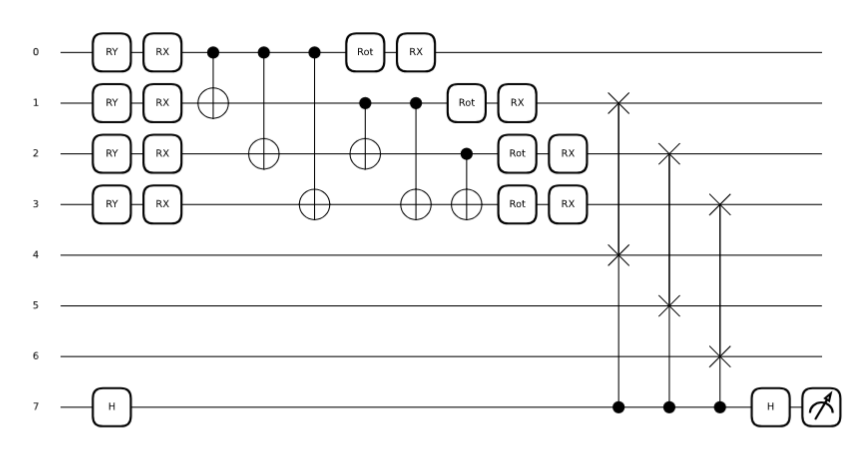

---



Sin terminar. Si lees esto Miriam. Ya se que esta mal JAJAJAJA

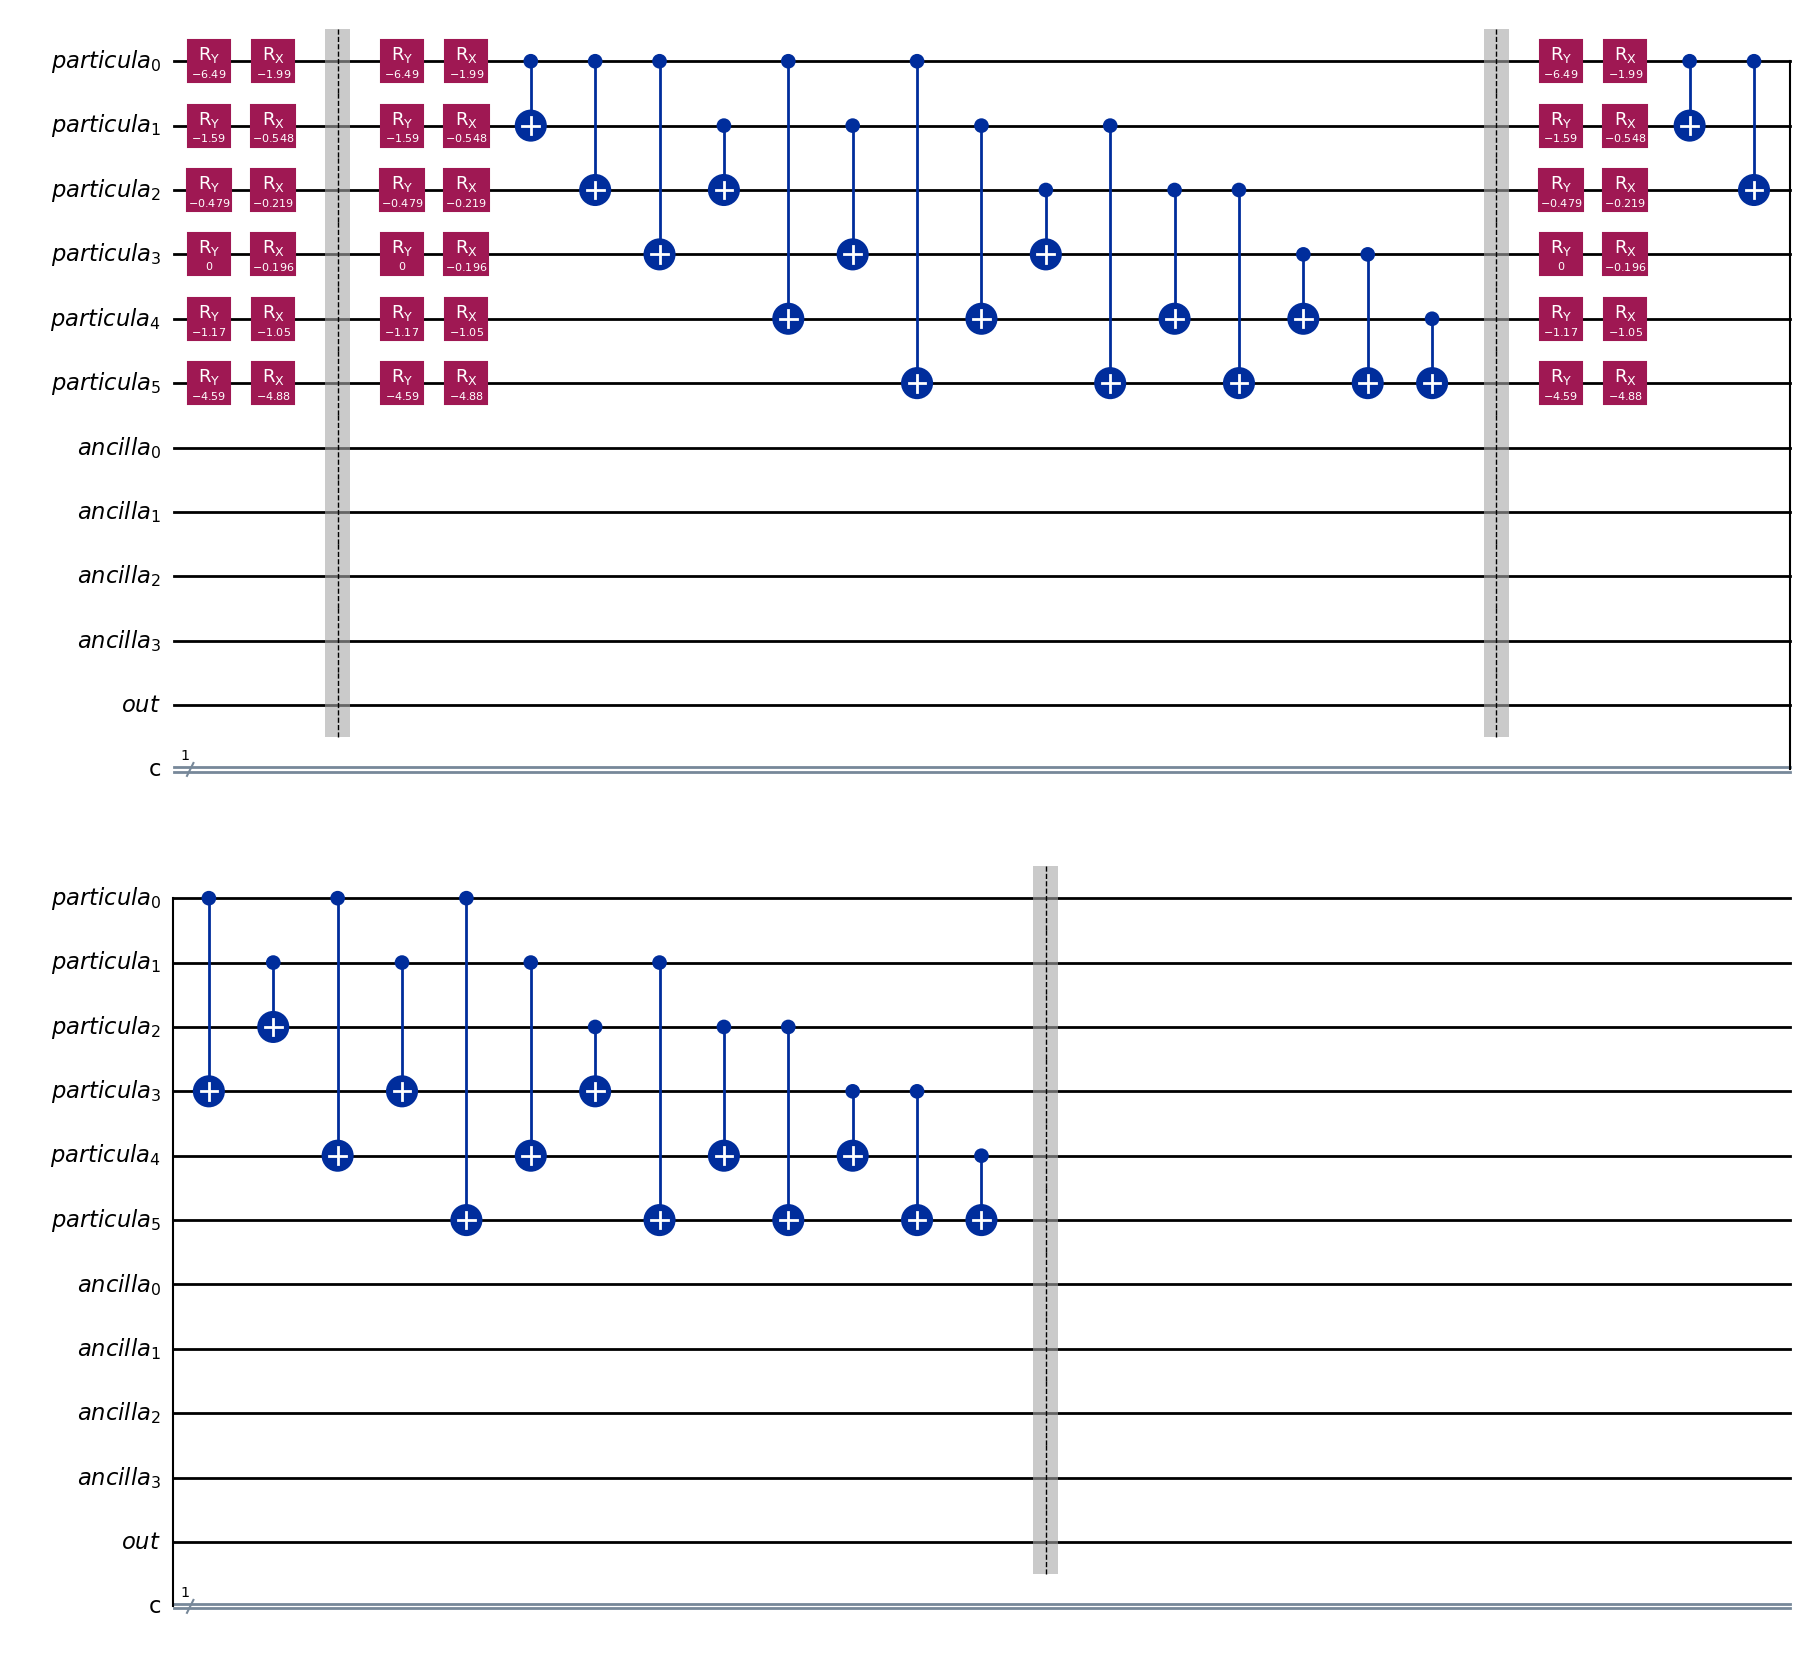

In [26]:
def encoder_1p1q(w, depth):
  q_data = QuantumRegister(n_latent, name='particula')       # q0–q3
  q_anc = QuantumRegister(n_trashes, name='ancilla')     # q4–q8
  q_out = QuantumRegister(1, name='out')         # q9
  c = ClassicalRegister(1, name='c')   #para medir
  qc = QuantumCircuit(q_data, q_anc, q_out, c)


  #-- ENCODING INICIAL --
  for i in range(n_latent):
      phi = phi_circuit(w, top_jets_float[i]['phi'], phi_jet, top_jets_float[i]['pt'], pt_jet)
      theta = theta_circuit(w, top_jets_float[i]['eta'], eta_jet, top_jets_float[i]['pt'], pt_jet)
      qc.ry(theta, i)
      qc.rx(phi, i)
  #-- ANSATZ --
  qc.barrier()
  for _ in range(depth):
    for i in range(n_latent):
      phi = phi_circuit(w, top_jets_float[i]['phi'], phi_jet, top_jets_float[i]['pt'], pt_jet)
      theta = theta_circuit(w, top_jets_float[i]['eta'], eta_jet, top_jets_float[i]['pt'], pt_jet)
      qc.ry(theta, i)
      qc.rx(phi, i)
    for i in range(n_latent):
      for j in range(i , n_latent - 1):
        qc.cx(i, j + 1)
    qc.barrier()
  return qc

qc = encoder_1p1q(w=1.0, depth=2)
qc.draw('mpl')